In [19]:
%config InlineBackend.figure_formats = ['svg']

I've been playing around with Claude Code, and I wanted to see what happens when you give it something genuinely open-ended. Not "implement this feature" or "fix this bug" but something that would typically require actual creativity from a human. Something where the agent needs to look at a landscape of existing solutions, find the gaps, and make something new.

The [Iterated Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma#The_iterated_prisoner's_dilemma) felt perfect for this. It's a well-studied problem with decades of research and it allows you to objectively measure how good your strategy is by running a tournament. So I gave Claude Code (Sonnet 4.5) one prompt to look at the [Axelrod library's](https://github.com/Axelrod-Python/Axelrod) 200+ IPD strategies, come up with something novel that could actually compete, and build it.

### Time For Some Game Theory

The traditional [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma) is one of game theory's most studied problems. Two players simultaneously choose to either **Cooperate** or **Defect**. The payoff matrix creates a tension between individual and collective benefit:

|                          | You Cooperate           | You Defect             |
|--------------------------|-------------------------|------------------------|
| **Opponent Cooperates**  | R = 3 (Reward)          | T = 5 (Temptation)     |
| **Opponent Defects**     | S = 0 (Sucker's payoff) | P = 1 (Punishment)     |


The dilemma: mutual cooperation yields 3 points each (Reward), but you're tempted to defect for 5 points while your opponent gets 0 (Sucker's payoff). But if you both defect, you each only get 1 point.

**In a one-shot game, rational self-interest says defect.** But what if you play repeatedly?

In 1980, political scientist [Robert Axelrod](https://en.wikipedia.org/wiki/Robert_Axelrod_(political_scientist)) adjusted the idea, and organized a computational tournament where experts across various fields submitted strategies for the **Iterated Prisoner's Dilemma (IPD)**. The traditional Prisoner’s Dilemma was a single, one-shot game: two players choose cooperate or defect once, receive payoffs, and the interaction ends. Axelrod’s Iterated Prisoner's Dilemma instead pits many strategies against each other in a round-robin tournament, where each pair plays the same opponent repeatedly over many rounds and total scores are accumulated. Because moves can depend on the history of play, strategies can reward cooperation, punish defection, and recover from mistakes.

The winner was [Anatol Rapoport](https://en.wikipedia.org/wiki/Anatol_Rapoport) and his strategy **[Tit For Tat](https://en.wikipedia.org/wiki/Tit_for_tat)**: start by cooperating, then mirror your opponent's last move. The simplicity surprised everyone. More complex strategies lost to this extremely basic algorithm.

Axelrod's 1984 book *[The Evolution of Cooperation](https://en.wikipedia.org/wiki/The_Evolution_of_Cooperation)* analyzed why:

- **Nice strategies** (never defect first) tended to win in the long run
- **Forgiving strategies** (don't hold grudges forever) did well
- **Clear strategies** (opponents can understand your pattern) encouraged cooperation
- **Retaliatory strategies** (punish defection) prevented exploitation

The key discovery was that while the traditional Prisoner’s Dilemma elevated defection as the logical play, the Iterated Prisoner's Dilemma tended to reward cooperation. These findings influenced fields from evolutionary biology to international relations. If cooperation can emerge from pure self-interest in simple games, perhaps it can explain cooperation in nature and human societies. [Veritasium did a great video summarizing the book](https://www.youtube.com/watch?v=mScpHTIi-kM), but you should read the book!

The [Axelrod library](https://github.com/Axelrod-Python/Axelrod) continues this research. It's a comprehensive Python framework containing:

- 200+ strategy implementations (classic and modern)
- Tournament infrastructure
- Statistical analysis and visualization tools
- [Moran process](https://en.wikipedia.org/wiki/Moran_process) simulation for evolutionary dynamics
- Support for noise, probabilistic endings, and spatial tournaments

Strategies range from simple ([Tit For Tat](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.titfortat.TitForTat), [Grudger](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.grudger.Grudger)) to complex (neural networks, finite state machines, zero-determinant strategies). It's maintained by researchers and serves as a testbed for game theory experiments.

### Claude In The Tournament

So I cloned the Axelrod library and gave Claude Code this prompt:

> *This is the Axelrod python library that implements the tournament-style iterative prisoners' dilemma popularized by Robert Axelrod in his seminal work The Evolution of Cooperation. We're going to try to create a novel and competitive strategy, one that stands on its own and can reliably compete with the bests known strategies, like Tit-For-Tat. The repository ships with over 200 strategies already for the tournament. I would like you to think hard about what a novel new strategy could be. This is going to require creativity and thinking outside the box. It'll likely take some iteration too. Let's begin. Explore the repository for existing strategies, understand how the tournament system works, and then, once you've created a novel and creative idea, implement the new strategy. Once implemented, run it in a tournament to see how it performs against all others.*

The interesting part here is what I didn't specify. I didn't tell it to use any particular approach. I just said: be novel, be competitive, figure it out. This is different from most coding tasks, and different from how I typically advise users getting started with AI tools. It requires the agent to do research, synthesize information, identify opportunities, and validate its own work.

The agent started by exploring. It read through the strategy implementations systematically, looking through dozens of Python files, each containing multiple strategies. It looked at how tournaments work, how strategies are classified, what the existing approaches are.

Then it started cataloguing: memory-based strategies that track opponent history, stochastic strategies that use randomness, zero-determinant strategies that unilaterally enforce a linear relationship between players' expected payoffs, evolved strategies optimized through genetic algorithms.

> `I'll help you create a novel and competitive strategy for the Iterated Prisoner's Dilemma! This is an exciting challenge. Let me start by exploring the repository to understand the existing strategies and tournament mechanics.`

After looking through all those approaches, the agent landed on a pretty specific gap: nobody was doing Bayesian opponent modeling in the straightforward way you’d expect. Lots of strategies adapt. Some keep simple stats like “how often does this opponent cooperate?” Some try to bucket opponents into types. But I didn’t see any that keep an explicit range of beliefs about how cooperative the other player is, and then use how confident (or uncertain) they are in that read to decide when to forgive or punish.

> `Based on my analysis, I'm going to create a strategy that fills a critical gap: Bayesian opponent modeling with uncertainty-aware decision making.`

That became the core insight: use uncertainty as a guardrail. When you don’t know what you’re dealing with yet, don’t hand out forgiveness cheaply. But once you’ve got enough evidence that an opponent is usually cooperative, you can afford to treat an occasional defection as noise, and forgive it, while still clamping down hard on players who keep defecting.

### Claude's Strategy

The strategy Claude Code designed has a simple core idea: model your opponent's cooperation probability using a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution), and let your uncertainty affect how forgiving you are.

The Beta distribution is perfect for this. You're uncertain about the opponent's true cooperation rate, so you maintain a distribution of possible values.

- **α (alpha)**: observed cooperations + prior
- **β (beta)**: observed defections + prior
- **Mean cooperation probability**: $\mu = \frac{\alpha}{\alpha + \beta}$
- **Uncertainty (standard deviation)**: $\sigma = \sqrt{\frac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)}}$

Start with `Beta(1,1)`, which is completely flat from 0 to 1. You have no idea if they'll cooperate or not.

Every time they cooperate, you increment α. Every time they defect, you increment β. The distribution gradually shifts and narrows as you observe more data. After 100 rounds with 70 cooperations, you've got `Beta(71, 31)`, a distribution peaked around 70% cooperation with relatively low uncertainty. After just 5 rounds with 3 cooperations, you've got `Beta(4, 3)`, which is still pretty uncertain.

Early on, uncertainty is high, which raises the forgiveness threshold, so the strategy is conservative about forgiving. As evidence accumulates, uncertainty shrinks and the threshold falls back toward the base threshold, making forgiveness possible once the estimated cooperation rate is convincingly high.

The decision rule is straightforward: if the opponent just cooperated, cooperate back. If they just defected, check their cooperation rate. If it's above your current threshold, forgive them and cooperate. If it's below, defect.

This creates adaptive behavior. Against cooperative opponents, you quickly learn they're trustworthy and maintain cooperation. Against occasionally exploitative opponents, confidence gives them a chance to reform. Against consistently hostile opponents, you become confident in their hostility and stop forgiving.

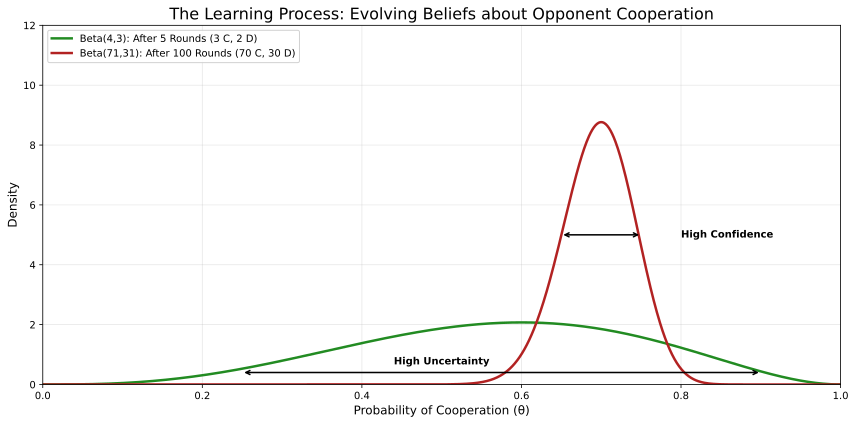

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

# Setup the data
x = np.linspace(0, 1, 1000)
y_early = beta.pdf(x, 4, 3)
y_late = beta.pdf(x, 71, 31)

# Create the plot
plt.figure(figsize=(12, 6), dpi=150)

# Plot the curves
plt.plot(x, y_early, label='Beta(4,3): After 5 Rounds (3 C, 2 D)', 
         color='forestgreen', linewidth=2.5)
plt.plot(x, y_late, label='Beta(71,31): After 100 Rounds (70 C, 30 D)', 
         color='firebrick', linewidth=2.5)

# 3. Styling
plt.title('The Learning Process: Evolving Beliefs about Opponent Cooperation', fontsize=16)
plt.xlabel('Probability of Cooperation (θ)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 12)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=10, framealpha=0.9)

# Annotations

plt.annotate('', xy=(0.25, 0.4), xytext=(0.9, 0.4),
             arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
plt.text(0.5, 0.6, 'High Uncertainty', 
         ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

plt.annotate('', xy=(0.65, 5.0), xytext=(0.75, 5.0),
             arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
plt.text(0.8, 5.0, 'High Confidence', 
         ha='left', va='center', fontsize=10, color='black', fontweight='bold')

# Show
plt.tight_layout()
plt.show()
            

Claude Code implemented this cleanly, largely thanks to the excellent documentation provided by the library. It wrote the strategy with proper parameter handling, reset logic, and classification metadata. It registered the strategy in the library's index. It wrote comprehensive tests.

The test suite is thorough. Basic behavior tests included expectations like "cooperate on first move" and "maintain cooperation with always-cooperate opponent." Edge case tests against [Defector](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.defector.Defector) and [Alternator](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.alternator.Alternator). Strategy mechanics tests to verify the Bayesian updating works correctly. A clone test to ensure parameters are preserved.

### Iterating and Improving

After it ran an initial tournament of BayesianForgiver against classic strategies, it decided to tune the strategy's default parameters:

> `I'll create a tournament script that imports and runs the strategy against others. Let me check if there are existing examples of running tournaments.`

...

> `Great! The tournament ran successfully! BayesianForgiver ranked 9th out of 15 in the classic tournament. This is decent but there's room for improvement. The results show that the strategy is working but could be tuned better.`

... 

> `The strategy is novel and functional, but let me try tuning the parameters to improve performance`

...

> `Excellent! The parameter tuning found significantly better parameters! Let me update the strategy with the optimized parameters`

This landed it at **6/15** in a smaller classic tournament against core strategies:

  - [**Tit For Tat**](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.titfortat.TitForTat) - The original champion: cooperate first, then mirror opponent's
  last move
  - [**Cooperator**](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.cooperator.Cooperator) - Always cooperates unconditionally
  - [**Defector**](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.defector.Defector) - Always defects unconditionally
  - [**Grudger**](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.grudger.Grudger) - Cooperates until the opponent defects once, then defects forever
  - [**Tit For 2 Tats**](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.titfortat.TitFor2Tats) - Only defects after two consecutive defections by opponent
  - [**Win-Stay Lose-Shift**](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.memoryone.WinStayLoseShift) - If the last round produced a good payoff,
  repeat; if bad, switch
  - [**GTFT**](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.memoryone.GTFT) - Generous Tit For Tat: occasionally cooperates even after opponent defects
  - [**Random**](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.rand.Random) - Randomly chooses between cooperation and defection with equal probability
  - [**Suspicious Tit For Tat**](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.titfortat.SuspiciousTitForTat) - Like Tit For Tat but starts by defecting
  instead of cooperating
  - [**Hard Tit For Tat**](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.titfortat.HardTitForTat) - Defects after any defection and only cooperates after
  three consecutive cooperations
  - [**Adaptive**](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.adaptive.Adaptive) - Learns from history: plays the response that would have maximized
  its own score
  - [**Adaptive Pavlov 2011**](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.apavlov.APavlov2011) - Classifies opponents into types and adapts strategy
  based on opponent classification
  - [**Forgiving Tit For Tat**](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.forgiver.ForgivingTitForTat) - Like Tit For Tat but forgives defections
  with 10% probability
  - [**Go By Majority**](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.gobymajority.GoByMajority) - Cooperates if opponent has cooperated more than
  defected in history

In a tournament where each pair of strategies plays 20 separate matches of 200 rounds:

| Rank     | Strategy                                  | Avg Score    |
|---------:|-------------------------------------------|-------------:|
| 1        | Grudger                                   | 7956.40      |
| 2        | Win-Stay Lose-Shift                       | 7914.90      |
| 3        | Adaptive Pavlov 2011                      | 7880.00      |
| 4        | Tit For 2 Tats                            | 7763.20      |
| 5        | Forgiving Tit For Tat                     | 7741.95      |
| **6**    | **Bayesian Forgiver**                     | **7735.55**  |
| 7        | Tit For Tat                               | 7733.95      |
| 8        | Hard Tit For Tat                          | 7554.35      |
| 9        | GTFT                                      | 7538.10      |
| 10       | Go By Majority                            | 7354.30      |
| 11       | Cooperator                                | 6912.60      |
| 12       | Adaptive                                  | 6703.55      |
| 13       | Suspicious Tit For Tat                    | 6450.65      |
| 14       | Random                                    | 5713.20      |
| 15       | Defector                                  | 4725.20      |

### The Tournament

I then asked Claude Code to run a comprehensive tournament following the examples from the [tournament repository](https://github.com/Axelrod-Python/tournament).

BayesianForgiver ranked **93rd** out of 226 strategies. Top 41%.

Let's be clear: this isn't elite performance. The top positions are dominated by evolved strategies based on finite state machines, neural networks, hidden Markov models that were optimized via evolutionary algorithms specifically for IPD success. But here's what matters: BayesianForgiver introduced a genuinely novel approach and proved it's competitive with those hand-crafted strategies. It beat some famous names from the literature. And it validated the core insight about certainty-aware forgiveness.

[Win-Stay, Lose-Shift](https://axelrod.readthedocs.io/en/stable/reference/strategy_index.html#axelrod.strategies.memoryone.WinStayLoseShift) (WSLS), also called Pavlov, is one of the landmark strategies in Iterated Prisoner's Dilemma research. A key modern reference point is [Nowak and Sigmund's 1993 paper](https://pubmed.ncbi.nlm.nih.gov/8316296/), which highlighted WSLS/Pavlov and showed that it can outperform Tit For Tat in a range of settings. The rule is elegantly simple: if the last round produced a "good" payoff, repeat your previous move; if it produced a "bad" payoff, switch.

The strategy is famous for its ability to correct mistakes and re-establish cooperation under noise: a single accidental defection doesn't necessarily lock WSLS into long retaliation cycles, and two WSLS players can often return to mutual cooperation quickly. It has been extensively studied in the theoretical and evolutionary game theory literature.

WSLS also has a well-known weakness in heterogeneous tournaments. Because it is a deterministic, memory-one rule that reacts only to the last outcome, it can be systematically exploited by certain opponents, such as those that defeat WSLS every other round by keeping it trapped in an alternating pattern. More generally, without modeling longer-term opponent behavior, WSLS can get pulled into unfavorable cycles against particular defection patterns.

**BayesianForgiver ranked above WSLS** in the comprehensive tournament (rank 93 vs. rank 108). This was extremely validating.

BayesianForgiver doesn't overreact to single defections; it builds a statistical model. As the game progresses, the Beta distribution captures the opponent's cooperation pattern. The adaptive threshold prevents getting locked into bad cycles while maintaining cooperation with reasonable opponents.

### Agentic Success

Let's zoom out and look at what actually happened here.

Claude Code took an open-ended challenge and executed the full lifecycle: autonomous research through 200+ strategies, novel design creating a Bayesian opponent-modeling strategy, complete implementation with proper structure and tests based on the library's documentation, self-initiated optimization, iterative improvement raising performance from rank, large-scale validation, and comprehensive documentation of everything.

This isn't remarkable because "AI can code." We know that. It's remarkable because of what happened in between: the creative ideating, the autonomous decision to optimize, the ability to validate its own work objectively.

The Iterated Prisoner's Dilemma turns out to be an ideal testbed for this. It's **well-defined** with clear rules and objective scoring. It's **well-studied** with hundreds of existing strategies to learn from. It's competitive with tournament rankings providing **objective evaluation**. And it's rich enough that despite all that existing work, **gaps still exist**.

This combination lets the agent verify its work objectively, learn from existing solutions, iterate based on data, and balance creativity with rigor. Those are exactly the capabilities that matter for real engineering work.

I think this is generalizable to other problem domains. Remember: agents are just [LLMs using tools in a loop](https://simonwillison.net/2025/Sep/18/agents/) and [you can definitely write your own](https://fly.io/blog/everyone-write-an-agent/).

With a few key requirements, agents are likely to have more success in "creative" endeavors:

1. **Objective evaluation metric** - The agent needs to know if its solution is good
2. **Existing corpus of solutions** - Learn from prior art, identify gaps
3. **Ability to iterate** - Test variations, optimize parameters
4. **Constrained search space** - Not infinite possibilities, but creative freedom within boundaries

When you have all four of these, agentic coding can potentially handle (more of) the full loop from problem to solution. The human provides problem framing, constraint setting, pointers to existing work, and final evaluation and review. The agent provides exploration, creative solution design, implementation, empirical validation, and iterative improvement.

### Try It Yourself

You can install from my [fork](https://github.com/hodgesmr/Axelrod/tree/bayesian-forgiver-strategy) to try it yourself:

```bash
uv pip install "git+https://github.com/hodgesmr/Axelrod@bayesian-forgiver-strategy"
```

```python
import axelrod as axl

players = [
    axl.BayesianForgiver(),
    axl.TitForTat(),
    axl.Cooperator(),
    axl.Defector(),
    axl.Grudger(),
    axl.TitFor2Tats(),
    axl.WinStayLoseShift(),
    axl.GTFT(),
    axl.Random(),
    axl.SuspiciousTitForTat(),
    axl.HardTitForTat(),
    axl.Adaptive(),
    axl.APavlov2011(),
    axl.ForgivingTitForTat(),
    axl.GoByMajority(),
]

tournament = axl.Tournament(players=players, turns=200, repetitions=20)
results = tournament.play(progress_bar=True)

for i, name in enumerate(results.ranked_names):
    idx = results.players.index(name)
    avg_score = sum(results.scores[idx]) / len(results.scores[idx])
    print(f"{name} : {avg_score}")
```

Can you beat BayesianForgiver with your own strategy?